# Exploratory analysis

Man Ho Wong | March 24, 2022

*Jupyter notebooks are not rendered properly on Github sometimes. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/exploratory_analysis.ipynb) if that happens.*

# Overview


> **Data processing and analysis:**  
>`data_curation.ipynb`  
>`data_preprocessing.ipynb`  
>`exploratory_analysis.ipynb`  <-- You are here

This notebook is the third step of the data processing and analysis pipeline of the project. The goal here is to explore what kinds of analysis can be done with the data processed by [`data_preprocessing.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_preprocessing.ipynb), and whether further data cleaning is needed. Specifically, I will evaluate the following linguistic measurements commonly used in the assessment of child language development:
   - Mean length of utterance (MLU)
   - Type-to-token ratio (TTR)
   - Part-of-speech ratio such as noun-to-verb ratio (NTVR)
   - Word frequency
   - Variation set

Here are the three objectives of this notebook:
1. Identify the tools available for the above linguistic measurements:
    - Assess the tools available in the `PyLangAcq` package and identify their limitations
    - Develop custom functions specifically designed for this project
    - Demonstrate data analysis with the identified tools
2. Evaluate whether the data is adequate for the above linguistic measurements:
    - Is the sample size sufficient?
    - Is the sample distribution balanced so that fair comparison between different factors can be made?
3. Look for interesting observations in the data:
    - What is the age range of participants best suited for the above linguistic measurements?
    - What are factors (e.g. socioeconomic status, SES) that should be further investigated in the next step?

### Table of contents
1. Mean length of utterance (MLU)
    - 1.1 
    - 1.2
2. 

### Script header

In [1]:
# Python packages and modules required
from collections import Counter
from heapq import nlargest
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                          # For pretty printing
import pylangacq                       # For reading CHAT files
from tqdm import tqdm                  # For showing progress bar
from wordcloud import WordCloud as wc

# use ggplot style for figures
# plt.style.use('ggplot')

# Unpickle data
data_idx = pickle.load(open('../data/childes/data_idx.pkl', 'rb'))

# Pretty printing for better readability
# With this, you can print dict in compact format instead of one item
#   per line. Items will be in alphabetical order. Nested Dict will be printed 
#   with suitable indentation. It will also print Counter in descending order.
#   To use this, call cp.pprint()
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# Function to get all labels of a given variable (e.g. 'mot_edu')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

data_idx.head()

,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,Bates_Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,Bates_Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,Bates_Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,Bates_Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,Bates_Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


---

# 1 Mean length of utterance (MLU)

A common way to measure a child's linguistic productivity is to look at the child's mean length of utterance (MLU). It can be measured by morphemes (MLU-m) or by words (MLU-w). Let's take a look at an example, 'Adam' from the Brown corpus:

In [2]:
# Read 'Adam' in Brown corpus into a reader object
path = '../data_samples/childes/Brown.zip'
adam = pylangacq.Reader.from_zip(path, 'Adam')

In [3]:
# get 2nd utterance of 4th file in 'adam'
adam[5].utterances()[1]

Utterance(participant='CHI', tokens=[Token(word="don't", pos='mod', mor='do', gra=Gra(dep=1, head=3, rel='AUX')), Token(word='CLITIC', pos='neg', mor='not', gra=Gra(dep=2, head=1, rel='NEG')), Token(word='dog', pos='v', mor='dog', gra=Gra(dep=3, head=0, rel='ROOT')), Token(word='.', pos='.', mor='', gra=Gra(dep=4, head=3, rel='PUNCT'))], time_marks=None, tiers={'CHI': "don't dog .", '%mor': 'mod|do~neg|not v|dog .', '%gra': '1|3|AUX 2|1|NEG 3|0|ROOT 4|3|PUNCT', '%com': 'Adam repeated these utterances several times'})

## 1.1 Using `PyLangAcq` to get MLU

In this utterance, "Don't dog.", there are two words ("don't" and "dog") but three morphemes ("do", "not", "dog"), so the length of utterance by words and by morphemes would be 2 and 3 respectively. To get Adam's MLU-w or MLU-m, you can measure the length of each utterance in  `adam` and then calculate the average length for all utterances. `PyLangAcq` has two functions which you can use to get the MLU easily:

In [4]:
# print MLU of 4th file in 'adam'
print('MLU-w:', adam[5].mluw())
print('MLU-m:', adam[5].mlum())

MLU-w: [2.2562874251497007]
MLU-m: [3.1988023952095808]


These functions are very helpful for getting a sense of how your data looks like, but there are a few limitations that make them unsuited for some studies. For example, these functions count the punctuation period (.) as a word or empty string (e.g., the annotation for the punctuation period) as a morpheme. Consequently, utterances with no words but just punctuation would be included in the calculation of the mean. Besides, the `PyLangAcq` functions only return average values: you cannot get the distribution of utterance length, nor the median length (MdLU) or other MLU variants such as MLU3-w (mean length of three longest utterances by words).

## 1.2 Custom functions to get MLU-w and MLU-m

To overcome the limitations of `PyLangAcq` functions, I will use my custom functions in the analysis. These functions are not declared here in this notebook but in a separate `.py` file because they will also be called in other notebooks as well. The functions are stored in [`./etc/pittchat.py`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/etc/pittchat.py):

In [5]:
from etc.pittchat import utt_len_w as utt_len_w
from etc.pittchat import utt_len_m as utt_len_m

Usage examples:

In [6]:
POS_IGNORE = ["n:prop"]  # POS of tokens to be ignored

LUw_list = utt_len_w(adam[5])
LUm_list = utt_len_m(adam[5], ignore=POS_IGNORE)

print('Length of first 10 utterances by words:    ', LUw_list[0:10])
print('Length of first 10 utterances by morphemes:', LUm_list[0:10])

print('MLU-w:', np.mean(LUw_list))
print('MLU-m:', np.mean(LUm_list))
print('MdLU-w:', np.median(LUw_list))

print('MLU3-m:', np.mean(nlargest(3, LUm_list)))

Length of first 10 utterances by words:     [6, 2, 5, 1, 2, 2, 3, 1, 2, 2]
Length of first 10 utterances by morphemes: [6, 3, 5, 1, 2, 2, 2, 1, 1, 2]
MLU-w: 2.258992805755396
MLU-m: 2.276155717761557
MdLU-w: 2.0
MLU3-m: 10.333333333333334


Documentation is provided in these functions' docstrings:

In [7]:
? utt_len_w

Signature:  utt_len_w(f_reader, participants='CHI', ignore=[]) -> List[float]
Docstring:
Get a list of utterance length by words (MLU-w) for all the utterances
in the file_reader. 

Parameters
f_reader : pylangacq.Reader object
           A pylangacq reader object of *one* CHAT file, or a reader of a
           collection of CHAT files indexed to *one* CHAT file.
participants : str or list[str], optional, default 'CHI' 
               The participant(s) whose tokens will be extracted from.
ignore : str or list[str], optional, default []
         The words to be ignored.

Returns
List[float] or 0 if no utterance found

Remarks
- WORDS_TO_IGNORE (basic list of words to be ignored) is the same as in
  pylangacq.Reader.mluw .
File:      d:\manho\documents\data_science\child-vocab-development\code\etc\pittchat.py
Type:      function


## 1.3 Comparing MLU-m between childen of different SES

In [8]:
ses_list = ['UC', 'MC', 'WC']
paths = {}
readers = {}

# read CHAT files into separate readers according to SES 
print('Reading CHAT files...')
for s in tqdm(ses_list):
    paths[s] = data_idx[data_idx.ses == s].file_path
    readers[s] = pylangacq.Reader.from_files(paths[s])

print('Done!')

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:42<00:00, 34.29s/it]

Done!


In [9]:
LUm_list = pd.DataFrame(columns=ses_list)  # List of utterance length (morpheme)
age_list = pd.DataFrame(columns=ses_list)  # List of child age

# Custom function to convert age in ymd format to age in months
from etc.pittchat import get_age_m as get_age_m

# For each SES group, get utterance length and child age of each file
for s in ses_list:
    for f in range(len(paths[s])):
        LUm_list.loc[f,s] = utt_len_m(readers[s][f])
        age_list.loc[f,s] = get_age_m(readers[s].ages()[f])

# List of MLU-m for all files
MLUm_list = LUm_list.applymap(lambda x: np.mean(x) if (x != np.nan) else x)

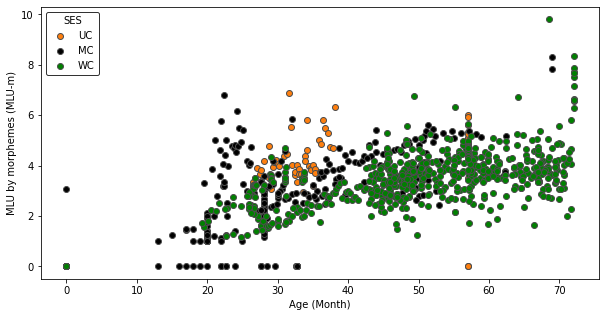

In [10]:
plt.figure(figsize=(10,5), facecolor='w')
cmap = {'UC':'tab:orange', 'MC':'k', 'WC':'g'}  # color map

# Scatter plot
for s in ses_list:
    plt.scatter(age_list[s], MLUm_list[s], facecolors=cmap[s], edgecolors='.3')

# Formatting
plt.xlabel('Age (Month)')
plt.ylabel('MLU by morphemes (MLU-m)')
plt.legend(ses_list, title='SES', edgecolor='k', loc='upper left')
plt.show()

Check age distribution:

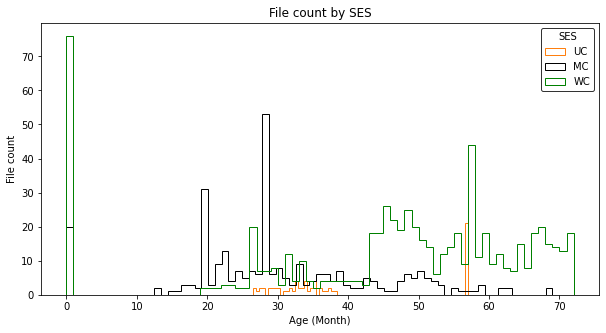

In [11]:
plt.figure(figsize=(10,5),facecolor='w')
cmap = {'WC':'g', 'MC':'k', 'UC':'tab:orange'}  # Color map
n_bin = int(max(age_list.max()))  # number of bins in histogram

# Plot histogram for each SES group
for s in ses_list:
    ages = age_list[s].dropna()  # drop NaN to avoid runtime warning
    plt.hist(ages, n_bin, histtype='step', edgecolor=cmap[s])

# Formatting
plt.xlabel('Age (Month)')
plt.ylabel('File count')
plt.title('File count by SES', fontsize='large')
plt.legend(ses_list, title='SES', edgecolor='k', loc='best')
plt.show()

Consider on age 18 to 42 months

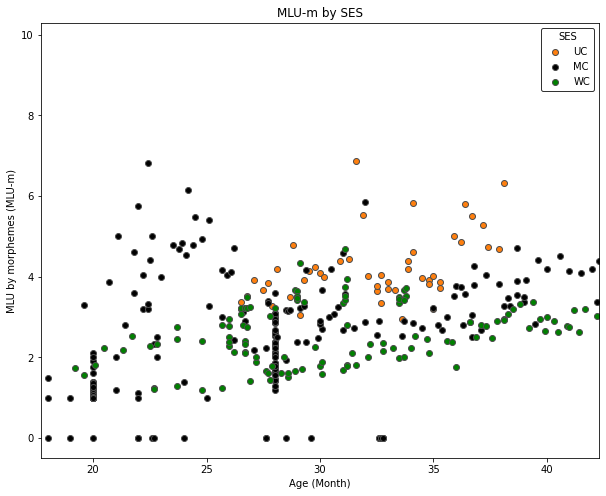

In [12]:
plt.figure(figsize=(10,8), facecolor='w')
cmap = {'UC':'tab:orange', 'MC':'k', 'WC':'g'}  # color map

# Scatter plot
for s in ses_list:
    plt.scatter(age_list[s], MLUm_list[s], facecolors=cmap[s], edgecolors='.3')

# Formatting
plt.xlabel('Age (Month)')
plt.ylabel('MLU by morphemes (MLU-m)')
plt.xlim([18-0.3,42+0.3])  # offset 0.5 to should datapoints completely
plt.title('MLU-m by SES', fontsize='large')
plt.legend(ses_list, title='SES', edgecolor='k', loc='best')
plt.show()

In [13]:
ses_list = ['UC', 'MC', 'WC']
paths = {}
readers = {}

# read CHAT files into separate readers according to SES 
print('Reading CHAT files...')
for s in tqdm(ses_list):
    paths[s] = data_idx[(data_idx.ses == s) & 
                        (data_idx.age_m>=18) & 
                        (data_idx.age_m<=42)].file_path
    readers[s] = pylangacq.Reader.from_files(paths[s])

print('Done!')

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:32<00:00, 10.70s/it]

Done!


In [14]:
LUm_list = pd.DataFrame(columns=ses_list)  # List of utterance length (morpheme)
age_list = pd.DataFrame(columns=ses_list)  # List of child age

# For each SES group, get utterance length and child age of each file
for s in ses_list:
    for f in range(len(paths[s])):
        LUm_list.loc[f,s] = utt_len_m(readers[s][f])
        age_list.loc[f,s] = get_age_m(readers[s].ages()[f])

#-------------------------------------------------------------------------------
# Utterance length statistics
        
# List of MLU-m for all files
MLUm_list = LUm_list.applymap(lambda x: np.mean(x) if (x != np.nan) else x)

# List of MLU100-m for all files (mean length of 5 longest utterances)
MLU100m_list = LUm_list.applymap(lambda x: np.mean(nlargest(100, x))
                               if ((x != np.nan) and (type(x)==list)) else x)

# List of MLU5-m for all files (mean length of 5 longest utterances)
MLU5m_list = LUm_list.applymap(lambda x: np.mean(nlargest(5, x))
                               if ((x != np.nan) and (type(x)==list)) else x)

# List of utterance length variance
VLUm_list = LUm_list.applymap(lambda x:  np.var(x) if
                                ((x != np.nan) and (type(x)==list)) else 0)

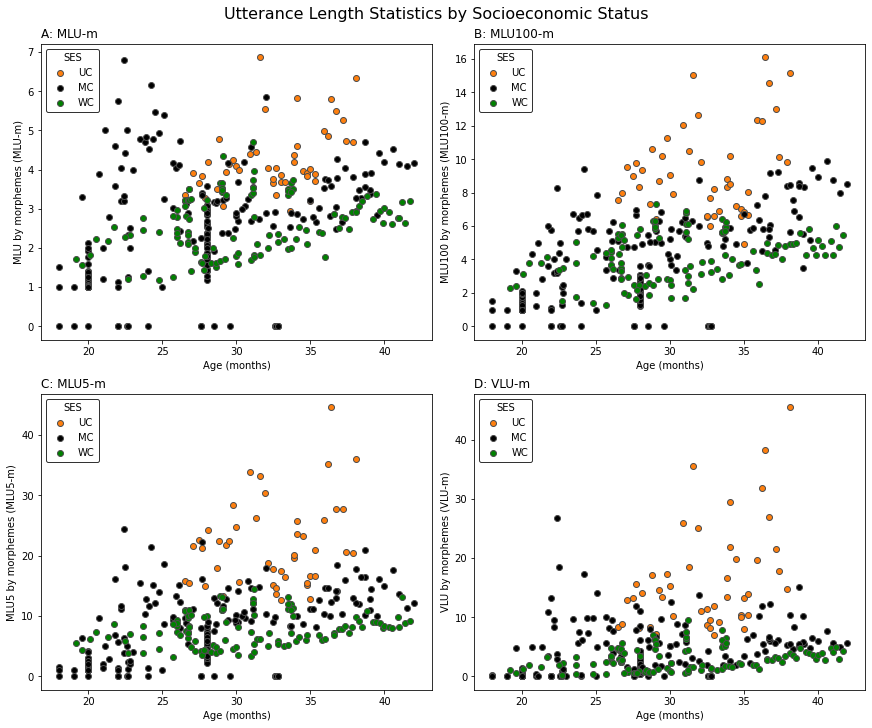

In [15]:
# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['MLU-m', 'MLU100-m'],
                              ['MLU5-m','VLU-m']],
                              figsize=(12,10), facecolor='w',
                              constrained_layout=True)
cmap = {'UC':'tab:orange', 'MC':'k', 'WC':'g'}  # color map

# Plot 4 subplots for each SES group
for s in ses_list:
    ax['MLU-m'].scatter(age_list[s], MLUm_list[s],
                        facecolors=cmap[s], edgecolors='.3')
    ax['MLU100-m'].scatter(age_list[s], MLU100m_list[s],
                           facecolors=cmap[s], edgecolors='.3')
    ax['MLU5-m'].scatter(age_list[s], MLU5m_list[s],
                         facecolors=cmap[s], edgecolors='.3')
    ax['VLU-m'].scatter(age_list[s], VLUm_list[s],
                        facecolors=cmap[s], edgecolors='.3')

# Set axis labels, subplot titles and legends
for k,v in {'A':'MLU-m', 'B':'MLU100-m', 'C':'MLU5-m', 'D':'VLU-m'}.items():
    ax[v].set_xlabel('Age (months)')
    ax[v].set_ylabel('{} by morphemes ({})'.format(v[:-2],v))
    ax[v].set_title('{}: {}'.format(k,v), loc = 'left')
    ax[v].legend(ses_list, title='SES', edgecolor='k', loc='upper left')

# Set figure title
fig.suptitle('Utterance Length Statistics by Socioeconomic Status',fontsize=16)

plt.show()

In [16]:
edu_dict = {'III':['MS', 'JD', 'DR'],
            'II':['AD', 'UG-', 'UG'],
            'I':['JH-', 'HS-', 'HS', 'HS+']}
paths = {}
readers = {}

print('Reading CHAT files...')
for level, labels in tqdm(edu_dict.items()):
    paths[level] = data_idx[data_idx.mot_edu.isin(labels)].file_path
    readers[level] = pylangacq.Reader.from_files(paths[level])

print('Done!')

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:37<00:00, 12.55s/it]

Done!


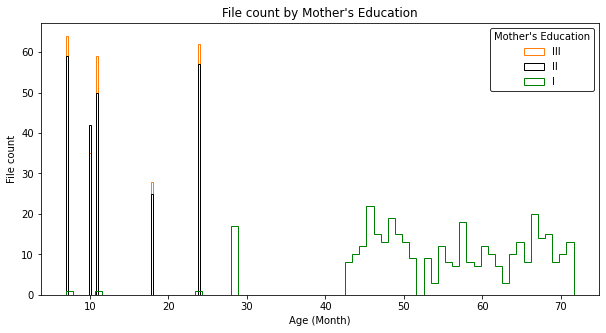

In [17]:
age_list = pd.DataFrame(columns=edu_dict.keys())  # List of child age
for level in edu_dict:
    for f in range(len(paths[level])):
        age_list.loc[f,level] = get_age_m(readers[level].ages()[f])

n_bin = int(max(age_list.max()))  # number of bins in histogram

plt.figure(figsize=(10,5),facecolor='w')
cmap = {'I':'g', 'II':'k', 'III':'tab:orange'}  # Color map

# Plot histogram for each SES group
for level in edu_dict:
    age_no_na = age_list[level].dropna()  # drop NaN to avoid runtime warning
    plt.hist(age_no_na, n_bin, histtype='step', edgecolor=cmap[level])
   
    
# Formatting
plt.xlabel('Age (Month)')
plt.ylabel('File count')
plt.title("File count by Mother's Education", fontsize='large')
plt.legend(edu_dict, title="Mother's Education", edgecolor='k', loc='best')
plt.show()

Education level II and III: age matched perfectly. Files seem to come from the same corpus.

Only compare level II and III:

In [18]:
edu_dict = {'III':['MS', 'JD', 'DR'],
            'II':['AD', 'UG-', 'UG']}

paths = {}
readers = {}

print('Reading CHAT files...')
for level, labels in tqdm(edu_dict.items()):
    paths[level] = data_idx[data_idx.mot_edu.isin(labels)].file_path
    readers[level] = pylangacq.Reader.from_files(paths[level])

print('Done!')

Reading CHAT files...


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.95s/it]

Done!


Get utterance length statistics:

In [19]:
LUm_list = pd.DataFrame(columns=edu_dict.keys())  # List of utterance length (morpheme)
age_list = pd.DataFrame(columns=edu_dict.keys())  # List of child age

# For each SES group, get utterance length and child age of each file
for level in edu_dict:
    for f in range(len(paths[level])):
        LUm_list.loc[f,level] = utt_len_m(readers[level][f])
        age_list.loc[f,level] = get_age_m(readers[level].ages()[f])

#-------------------------------------------------------------------------------
# Utterance length statistics
        
# List of MLU-m for all files
MLUm_list = LUm_list.applymap(lambda x: np.mean(x) if (x != np.nan) else x)

# List of MLU100-m for all files (mean length of 5 longest utterances)
MLU100m_list = LUm_list.applymap(lambda x: np.mean(nlargest(100, x))
                               if ((x != np.nan) and (type(x)==list)) else x)

# List of MLU5-m for all files (mean length of 5 longest utterances)
MLU5m_list = LUm_list.applymap(lambda x: np.mean(nlargest(5, x))
                               if ((x != np.nan) and (type(x)==list)) else x)

# List of utterance length variance
VLUm_list = LUm_list.applymap(lambda x:  np.var(x) if
                                ((x != np.nan) and (type(x)==list)) else 0)

Plot:

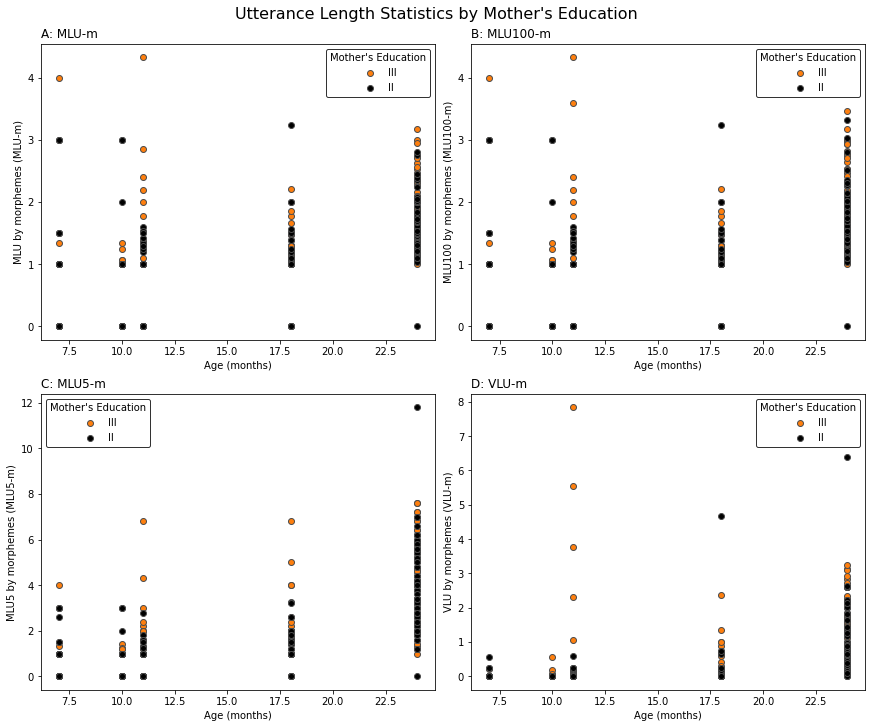

In [20]:
# Create a figure with 4 axes (i.e. 4 subplots)
fig, ax = plt.subplot_mosaic([['MLU-m', 'MLU100-m'],
                              ['MLU5-m','VLU-m']],
                              figsize=(12,10), facecolor='w',
                              constrained_layout=True)
cmap = {'II':'k', 'III':'tab:orange'}  # Color map

# Plot 4 subplots for each SES group
for level in edu_dict:
    ax['MLU-m'].scatter(age_list[level], MLUm_list[level],
                        facecolors=cmap[level], edgecolors='.3')
    ax['MLU100-m'].scatter(age_list[level], MLU100m_list[level],
                           facecolors=cmap[level], edgecolors='.3')
    ax['MLU5-m'].scatter(age_list[level], MLU5m_list[level],
                         facecolors=cmap[level], edgecolors='.3')
    ax['VLU-m'].scatter(age_list[level], VLUm_list[level],
                        facecolors=cmap[level], edgecolors='.3')

# Set axis labels, subplot titles and legends
for k,v in {'A':'MLU-m', 'B':'MLU100-m', 'C':'MLU5-m', 'D':'VLU-m'}.items():
    ax[v].set_xlabel('Age (months)')
    ax[v].set_ylabel('{} by morphemes ({})'.format(v[:-2],v))
    ax[v].set_title('{}: {}'.format(k,v), loc = 'left')
    ax[v].legend(edu_dict.keys(), title="Mother's Education", edgecolor='k')

# Set figure title
fig.suptitle("Utterance Length Statistics by Mother's Education",fontsize=16)

plt.show()

---

# 2 type-to-token ratio (TTR)


## 2.1 Using `PyLangAcq` to get TTR

## 2.2 Custom functions to get TTR

In [55]:
# TTR of CHI (same as pylangacq.Reader.ttr)
def get_ttr(reader, participants, ignore=[]):
    toks = reader.tokens(participants=participants)
    WORDS_TO_IGNORE = ["", "!", "+...", ".", ",", "?", "‡", "„", "0", "CLITIC"]
    WORDS_TO_IGNORE.extend(ignore)
    tok_list     = [t.word for t in toks if (t.word not in WORDS_TO_IGNORE)]
    if tok_list:
        return len(set(tok_list))/len(tok_list)
    else:
        return 0

get_ttr(adam[5], 'CHI')

0.15711252653927812

---

# 3 POS proportion

## 3.1 Custom function to get POS proportion

In [44]:
from etc.pittchat import get_pos_pro as get_pos_pro

In [45]:
# get proportion of nouns
print('Proportion of nouns:', get_pos_pro(adam[0], pos='n'))

# get noun-to-verb ratio (NTVR)
print('NTVR:', get_pos_pro(adam[0], pos='n', ref_pos=['n', 'v']))

Proportion of nouns: 0.48333333333333334
NTVR: 0.8093023255813954


---

# 4 Word frequency

In [46]:
# Read all files of UC children
paths = data_idx[data_idx.ses == 'UC'].file_path
f_UC = pylangacq.Reader.from_files(paths)

## 4.1 Using `PyLangAcq` to get word frequencies

In [47]:
freq = f_UC.word_frequencies()
cp.pprint(freq.most_common(20))

[('.', 108791), ('?', 38547), ('you', 28842), (',', 25647), ('I', 23034),
 ('the', 22485), ('it', 17342), ('a', 17194), ('and', 14434), ('that', 10587),
 ('to', 10426), ('what', 10166), ('yeah', 9588), ('!', 9588), ('this', 9348),
 ('...', 8558), ('is', 8265), ('no', 8213), ('in', 8073), ('on', 7170)]


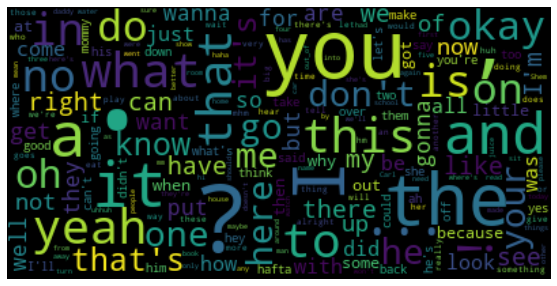

In [48]:
wcloud = wc(max_font_size=100).generate_from_frequencies(freq)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

## Self-defined function to get word frequencies by POS and ignore punctuations

In [49]:
# Define POS by open vs close word class
POS_OPEN = ["n", "v", "adv", "adj", "co"]
POS_CLOSE = ['mod', 'neg', 'cop', 'pro:exist', 'aux', 'part', 'det:art', 'comp',
             'post','pro:obj', 'pro:int', 'pro:per', 'coord', 'on', 'inf', 'qn',
             'pro:indef', 'pro:sub', 'pro:rel', 'prep', 'pro:dem', 'det:num']

from etc.pittchat import get_wfreq as get_wfreq
# get freq of one file in 'sample':
freq = get_wfreq(f_UC, pos=POS_OPEN)


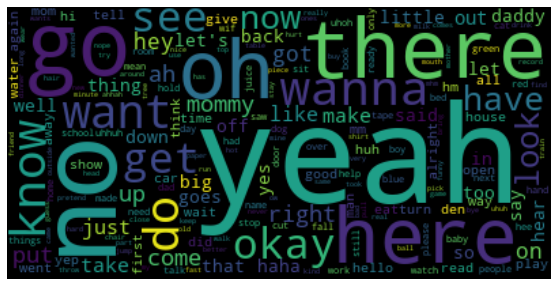

In [50]:
wcloud = wc(max_font_size=100).generate_from_frequencies(freq)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

In [51]:
from etc.pittchat import get_wfreq as get_wfreq
freq = get_wfreq(f_UC, pos='n')

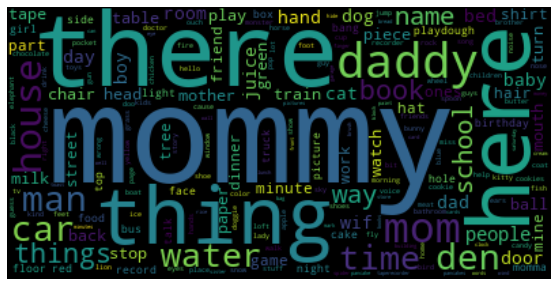

In [52]:
wcloud = wc(max_font_size=100).generate_from_frequencies(freq)
plt.figure(figsize=(10,5))
plt.axis("off")
plt.imshow(wcloud, interpolation='bilinear')
plt.show()

In [ ]:
rel_freq = { w : (f/sum(freq.values())) for w, f in freq.items() }
cp.pprint(rel_freq)

# sorted(rel_freq, reverse=True, key=rel_freq.get)

In [ ]:
freq = get_wfreq(f_UC)
rel_freq = { w : (f/sum(freq.values())) for w, f in freq.items() }

freq2 = get_wfreq(f_WC)
rel_freq2 = { w : (f/sum(freq2.values())) for w, f in freq2.items() }

In [ ]:
freq_300 =sorted(rel_freq, reverse=True, key=rel_freq.get)[0:300]
freq2_300 =sorted(rel_freq2, reverse=True, key=rel_freq2.get)[0:300]

list(set(freq_300).intersection(freq2_300))

---

# 5 Summary
